# **Portfolio Project: Using News Articles on Events in Nigeria in 2019 to Predict Political Violence**

---
---

### In this portfolio project, I explore whether news trends from a variety of news articles and news snippets on events in Nigeria in 2019 can predict several categories of violent political events tracked by the ACLED political violence dataset in 2019, including 1) battles, 2) explosions and remote violence, 3) protests in which authorities responded using excessive force, 4) riots, and 5) violence against civilians. I do so using Ridge, Lasso, Random Forest, and XGBoost Regression, comparing the results of these models in terms of RMSE.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from pandas.core.common import random_state
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
import pickle


In [2]:
the_path = "C:/Users/rsb84/Desktop/RB/portfolio_data/nigeria_news/"
export_path = "C:/Users/rsb84/Desktop/RB/portfolio_data/nigeria_news/export/"

In [3]:
df = pd.read_csv('Nigeria2019_ACLED_Extract.csv')

In [4]:
event_types = df[['week', 'event_type', 'sub_event_type']].copy()

In [5]:
event_types.head()

,week,event_type,sub_event_type
0,1,Battles,Armed clash
1,1,Battles,Armed clash
2,1,Explosions/Remote violence,Air/drone strike
3,1,Violence against civilians,Attack
4,1,Battles,Armed clash


### Note: I used Excel's =WEEKNUM(date) to create an extra column in which the date was converted into the week number of the year. I did so so that I could later group corresponding weekly observations of news text-based features to predict the occurence of event_types in the ACLED dataset.


### The ACLED dataset contains 6 different event types, each comprising various sub-event types. The "strategic developments" event type is the only completely non-violent event type. The event type of "protests" contains the sub-event types of 1) "peaceful protest", 2) "protest with intervention", and 3) "excessive force against protesters". "Protest with intervention" is defined as "a peaceful protest during which there is an attempt to disperse or suppress the protest without serious/lethal injuries being reported or the targeting of protesters with lethal weapons." (ACLED Codebook, pg. 15). Since I am only interested in predicting violent event types, I will first delete observations in which the event type is "strategic developments" or the sub-event types are "peaceful protest" or "protest with intervention". Please see the ACLED Codebook for information about the dataset: https://acleddata.com/acleddatanew/wp-content/uploads/2021/11/ACLED_Codebook_v1_January-2021.pdf

In [6]:
event_types = event_types.loc[~(event_types['event_type'] == 'Strategic developments'),:]
event_types = event_types.loc[~(event_types['sub_event_type'] == 'Peaceful protest'),:]
event_types = event_types.loc[~(event_types['sub_event_type'] == 'Protest with intervention'),:]

### Here, I one hot encode each event type categorical variable (using pandas get_dummies) so that my machine learning models can process them:

In [7]:


event_types_dummies = pd.get_dummies(event_types[['event_type']])

In [8]:
event_types_dummies.head()

,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,0,1
4,1,0,0,0,0


In [9]:
event_types_dummies.shape

(1492, 5)

In [10]:
event_types.shape

(1492, 3)

### Here, I combine the week column of my above event_types dataframe with all the one-hot-encoded event_type variables in the event_types_dummies dataframe. Otherwise, if you use pd.get_dummies on event_types as a whole without separating out the week column from the event types, it will one hot encode the weeks as well, which is not what I want to do:

In [11]:
event_types_combined = pd.concat([event_types[['week']], event_types_dummies], axis=1) 

In [12]:
event_types_combined.shape

(1492, 6)

In [13]:
event_types_combined.head()

,week,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians
0,1,1,0,0,0,0
1,1,1,0,0,0,0
2,1,0,1,0,0,0
3,1,0,0,0,0,1
4,1,1,0,0,0,0


### Here, I group all event type variable counts, summed by the corresponding week the events occurred in:

In [14]:


event_types_by_week = event_types_combined.groupby(['week']).sum()

In [15]:
event_types_by_week.shape

(53, 5)

In [16]:
event_types_by_week.head()

,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians
week,,,,,
1,18,4,0,1,5
2,10,0,0,1,6
3,11,0,0,7,11
4,17,1,1,6,6
5,10,3,0,5,13


In [17]:
event_types_by_week = event_types_by_week.reset_index()

In [18]:
event_types_by_week = pd.DataFrame(event_types_by_week)

### Now, I import the news articles and news snippets on events in Nigeria in 2019, and begin to prepare each corpus to be grouped by week of the year

In [23]:

newsfeed = pd.read_csv("newsfeed.csv")

In [24]:
newsfeed.columns

Index(['week', 'text'], dtype='object')

In [25]:
newsfeed = newsfeed.sort_values(by="week")

In [26]:
newsfeed.shape

(24355, 2)

### There are 24,355 news articles and news snippets, with the week of the year in which each article or snippet was written stated in the column prior to the news articles/snippets. The lambda function below concatenates all new articles/snippets into a SINGLE row depending on the week of the year in which each news article/snippet was written.

In [27]:
newsfeed_by_week = newsfeed.groupby('week')['text'].apply(lambda x:x.str.cat(sep=" "))

In [28]:
newsfeed_by_week = pd.DataFrame(newsfeed_by_week)

In [29]:
newsfeed_by_week = newsfeed_by_week.reset_index()

In [30]:
newsfeed_by_week['week'].values

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53], dtype=int64)

---
---

### We see from the code above that there are no news articles or snippets in the dataset which were written during week 1. All other weeks of the year have newsfeeds. However, since week 1 is misssing from the newsfeed_by_week dataframe, we will also need to eliminate the week 1 row from the ACLED event_types_by_week dataframe (below) to make sure the features and the targets have the same number of rows. 

### We will also need to first difference the newsfeed data because there is likely non-stationarity in the data. First differncing will result in the first row - i.e., week 2 - having missing values and thus also needing to be deleted. Further, after first differencing results in week 2 being deleted, we will need to take lags of each column of the newsfeed dataset and add the lags to the dataset. Since the act of taking a lag results in a missing value for the first row in a given lagged column, this will result in the remaining first column (week 3) also being deleted. 

### Thus, to make sure our target variables have the same number of rows as our feature variables, I will delete weeks 1, 2, and 3 from the event type data below. This will ultimately leave us with 50 remaining rows (weeks) of data for both the features and the targets:

---
---

In [47]:
event_types_by_week['week'].values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53], dtype=int64)

In [48]:
event_types_by_week_50_wks = event_types_by_week.iloc[3: , :] #This removes the first 3 rows (weeks 1 - 3) from the dataframe

In [49]:
event_types_by_week_50_wks.head()

,week,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians
3,4,17,1,1,6,6
4,5,10,3,0,5,13
5,6,15,1,0,10,24
6,7,13,2,0,4,49
7,8,21,2,0,4,27


In [50]:
event_types_by_week_50_wks.shape

(50, 6)

In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rsb84\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Here, I create some functions in python that ensure that all text in the dataframe is lowercase, and that stopwords are removed:

In [52]:
def rem_sw(var):
    from nltk.corpus import stopwords
    sw = stopwords.words('english')
    sw = set(sw)
    new_sw = {"said", "says", "saying", "say", "us", "since", "like", "likes", "people"}
    sw = sw.union(new_sw)
    tmp = var.split() #tokenizinng words here
    fin_var = [word for word in tmp if word not in sw] #removing stopwords
    fin_var = ' '.join(fin_var) #rejoining tokenized words (without stopwords)
    return fin_var

In [53]:
newsfeed_by_week['text_lower'] = newsfeed_by_week.text.apply(lambda x: x.lower())
newsfeed_by_week['text_sw'] = newsfeed_by_week.text_lower.apply(rem_sw)

In [54]:
the_column1 = 'text_sw'

### A brief note on Term Frequency-Inverse Document Frequency (TF-IDF) Matrices:

### TF-IDF is a statistical measure of how relevant a particular word is for a given corpus in relation to all corpuses in a dataset. It's value for a given word in a document increases the more frequently the word occurs in the document, but is penalized by the number of documents overall which contain the word. The underpinning concept is that words which occur in many documents are likley to be less important/relevant than words that occur frequently in fewer documents. 

### Specifically, the term frequency (or the number of times the word under consideration occurs in a given document) is divided by the inverse-document frequency - a measure of the rarity of the word across the entire set of corpuses (log(1 + total number of documents/1 + document frequency of the term) + 1).

### The overall TF-IDF score ranges between 0 and 1, with higher scores implying greater word relevance.
---
---

### Below, I create a function that transforms the text using TF-IDF into numerical features that can be fit to machine learning models:

In [55]:
def my_tf_idf_sw(var, path_in):
    from sklearn.feature_extraction.text import TfidfVectorizer
    import pandas as pd
    import pickle
    my_tf_idf = TfidfVectorizer()
    my_tf_idf_vec = pd.DataFrame(my_tf_idf.fit_transform(var).toarray())
    my_tf_idf_vec.columns = my_tf_idf.get_feature_names_out()
    pickle.dump(my_tf_idf, open(path_in + "tf_idf_sw.pkl", "wb"))
    pickle.dump(my_tf_idf_vec, open(path_in + "tf_idf_df_sw.pkl", "wb" ) )
    return my_tf_idf_vec

In [56]:
news_tf_idf_sw = my_tf_idf_sw(newsfeed_by_week[the_column1], export_path)

### **The problems of non-stationarity and serial autocorrelation:**

### When using time series data, it is important to be sure that no regularly occurring and predictable pattern in the long-term will be present, a concept known as non-stationarity, as such time series data will result predictions which are a result of regularly recurring trends rather than underlying processes. Stationary time series data has a constant mean and variance in the series. "Trend Stationarity", whereby the data may not have a constant variance but does at least have a constant variance along the trend, is also acceptable. Taking the first difference of data is often used to resolve the problem of non-stationarity, which is what I do in this project.

### Machine learning algorithms make the assumption that the data is independent and identically distributed (i.i.d.). However, with time series data each observation is at least somewhat dependent on the prior observation because of each observation's relationship with time, called serial autocorrelation. In other words, if we reordered time period-based observations we would not expect to get equivalent results in our predictions. The residuals of time series observations are correlated; they are not independent of each other. To correct for autocorrelation of the residuals it is often necessary to include lags and sometimes other variables that account for time period. Differencing the data is also often helpful. In this project, I use first differencing and lags as a means of helping to address the problem. 

### With nearly 37,000 features I assume that non-stationarity and serial autocorrelation exist in my TF-IDF transfromed dataset.

### Below, I first difference all of my TF-IDF transformed features: 

In [57]:
news_tf_idf_sw_fd = news_tf_idf_sw.diff(periods=1)

In [58]:
news_tf_idf_sw_fd.shape

(52, 36829)

In [59]:
news_tf_idf_sw_fd = news_tf_idf_sw_fd.dropna(axis=0)

In [60]:
news_tf_idf_sw_fd.shape #Now week 2 has been deleted by dropping the first row of missing values left by first differencing

(51, 36829)

In [61]:
'''
pickle.dump(news_tf_idf_sw_fd, open(export_path + "news_tf_idf_sw_fd.pkl", "wb"))

In [ ]:
'''
news_tf_idf_sw_fd = pickle.load(open(export_path + "news_tf_idf_sw_fd.pkl", "rb"))

In [62]:
#Here, I create the target variables I will use my newsfeed datasets to attempt to predict using supervised machine learning models

y_battles = event_types_by_week_50_wks[['event_type_Battles']].copy()
y_explosions = event_types_by_week_50_wks[['event_type_Explosions/Remote violence']].copy()
y_protests = event_types_by_week_50_wks[['event_type_Protests']].copy()
y_riots = event_types_by_week_50_wks[['event_type_Riots']].copy()
y_vac = event_types_by_week_50_wks[['event_type_Violence against civilians']].copy()

In [63]:
print(y_battles.shape)
print(y_explosions.shape)
print(y_protests.shape)
print(y_riots.shape)
print(y_vac.shape)

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)


In [65]:
'''
pickle.dump(y_battles, open(export_path + "y_battles_50_wks.pkl", "wb"))
pickle.dump(y_explosions, open(export_path + "y_explosions_50_wks.pkl", "wb"))
pickle.dump(y_protests, open(export_path + "y_protests_50_wks.pkl", "wb"))
pickle.dump(y_riots, open(export_path + "y_riots_50_wks.pkl", "wb"))
pickle.dump(y_vac, open(export_path + "y_vac_50_wks.pkl", "wb"))


In [ ]:
'''
y_battle = pickle.load(open(export_path + "y_battles_50_wks.pkl", "rb"))
y_explosions = pickle.load(open(export_path + "y_explosions_50_wks.pkl", "rb"))
y_protests = pickle.load(open(export_path + "y_protests_50_wks.pkl", "rb"))
y_riots = pickle.load(open(export_path + "y_riots_50_wks.pkl", "rb"))
y_vac = pickle.load(open(export_path + "y_vac_50_wks.pkl", "rb"))


### Investigating non-stationarity in the dependent variable:
### With the Augmented Dickey-Fuller Test, we check whether the null hypothesis of presence of non-stationarity can be rejected for particular variables. We see that the p-value in most cases is less than 0.05; in these instances we can safely reject the null hypothesis. We do not need to first difference the target. We can see that only with y_protests (number of protests in a given week in which police respond with excessive force) and y_vac (events involving violence against civilians) are we unable to reject the null hypothesis, resulting in the assumption of non-stationarity being present.


In [66]:

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(y_battles)
print("ADF = " + str(adf_test[0]))
print("p-value = " +str(adf_test[1]))

ADF = -8.038047205293735
p-value = 1.87939942870067e-12


In [67]:
adf_test = adfuller(y_explosions)
print("ADF = " + str(adf_test[0]))
print("p-value = " +str(adf_test[1]))

ADF = -7.011085577942736
p-value = 6.919047048561405e-10


In [68]:
adf_test = adfuller(y_protests)
print("ADF = " + str(adf_test[0]))
print("p-value = " +str(adf_test[1])) #We cannot reject the null hypothesis of a unit root and non-statonarity since the p-value > 0.05.

ADF = -2.166443849384345
p-value = 0.21864897167202985


In [69]:
adf_test = adfuller(y_riots)
print("ADF = " + str(adf_test[0]))
print("p-value = " +str(adf_test[1]))

ADF = -5.660105937292464
p-value = 9.422640208691123e-07


In [70]:
adf_test = adfuller(y_vac)
print("ADF = " + str(adf_test[0]))
print("p-value = " +str(adf_test[1])) #We cannot reject the null hypothesis of a unit root and non-statonarity since the p-value > 0.05.

ADF = -1.6687567391397395
p-value = 0.4472775450272684


In [71]:
#We need to first difference y_protests and y_vac to make them stationary, but since I do not want to lose 
#the first row of these targets which will happen as a result of first differencing, I will add back an extra row (week 2) 
#before first differencing. This will result in 50 weeks worth of data like the other targets have. 

y_protests_orig = event_types_by_week[['event_type_Protests']].copy()
y_vac_orig = event_types_by_week[['event_type_Violence against civilians']].copy()

In [74]:
print(y_protests_orig.shape)
print(y_vac_orig.shape)

(53, 1)
(53, 1)


In [75]:
y_protests = y_protests_orig.iloc[2: , :]
y_vac = y_vac_orig.iloc[2: , :]

In [76]:
y_protests = y_protests.diff(periods=1).dropna(axis=0)
y_vac = y_vac.diff(periods=1).dropna(axis=0)

### We must keep in mind that the interpretation of the machine learning models in which this target is used will now change. We will now be trying to predict ***changes*** in the number of protests in which authorities used excessive force and to predict ***changes*** in the number of events involving violence against civilians based on weekly ***changes*** in the values of the features used in the model.

### For the other target variables (battles, explosions or remote violence, and riots), we will be trying to predict the ***overall number*** of such events based on weekly ***changes*** in the values of the features used in the model.

In [77]:
print(y_protests.shape)
print(y_vac.shape)

(50, 1)
(50, 1)


In [78]:
'''
pickle.dump(y_protests, open(export_path + "y_protests_diff.pkl", "wb"))
pickle.dump(y_vac, open(export_path + "y_vac_diff.pkl", "wb"))

In [ ]:
'''
y_protests = pickle.load(open(export_path + "y_protests_diff.pkl", "rb"))
y_vac = pickle.load(open(export_path + "y_vac_diff.pkl", "rb"))

---

### Below, I take one lag of each feature in the TF-IDF transformed dataset that has already been first differenced. I normally would want to account for many weeklong lags in the data since it is quite possible that sentiment in the news which occurred weeks or possibly even months prior to an event in a current week are predictive of that event occurring. However, I only have one year’s worth of data; since each time you take a lag you are in effect deleting one row of data, and since each row of data can be crucial in helping machine learning models determine predictive strength (particularly when starting with only 52 observations), in this portfolio example I default to using just one lag. It is noteworthy that AR(1) is the most common type of serial autocorrelation in the social sciences, even though the assumption of AR(1) - that there is only a strong correlation between adjacent time periods - may not be completely realistic in the case of my data. However, the fact that I have first differenced my data should on its own correct for much of the autocorrelation (as well as non-stationarity) likely to exist.

### Lag 1 results in the first row of a given dataset needing to be deleted because it creates a missing value (i.e., NA) in the first row for each lagged column. And even if there is only one missing value in a row, the whole row must be deleted, unless you can identify the value prior to the first row for each column of missing data that should exist, which we cannot since I only have news articles and news snippets from the year 2019 to work with. Remember that normally the first row that would have been deleted would have been week 1 of 2019, but since week 1’s data was already missing to begin with, week 2 became my first row (which was deleted as a result of first differencing). Thus, week 3 is in fact the row that will be deleted after creating 1 lag of each feature.

---


In [79]:
#The following code for building a function that creates lagged features and includes them in the same dataset 
#as the non-lagged features originates from the following website:
#https://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe

def buildLaggedFeatures(s,lag=1,dropna=True):

    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [80]:
news_df = buildLaggedFeatures(news_tf_idf_sw_fd, lag=1, dropna=True)
#So now weeks 1, 2 and 3 are no longer in the dataset.

In [81]:
news_df.shape

(50, 73658)

### Below, I divide the features into an overall training set composed of the first 80% of the observations in time order and reserve the remaining 20% for the test set. This approach differs from Sklearn's train_test_split in that it does not randomly shuffle the observations into train or test set, which would not preserve the time order of the data.

In [82]:
X_train, X_test= np.split(news_df, [int(.80 *len(news_df))])

In [83]:
X_train.shape

(40, 73658)

In [84]:
X_test.shape

(10, 73658)

In [85]:
y_battles_train, y_battles_test= np.split(y_battles, [int(.80 *len(y_battles))])

In [86]:
y_explosions_train, y_explosions_test= np.split(y_explosions, [int(.80 *len(y_explosions))])

In [87]:
y_protests_train, y_protests_test= np.split(y_protests, [int(.80 *len(y_protests))])

In [88]:
y_riots_train, y_riots_test= np.split(y_riots, [int(.80 *len(y_riots))])

In [89]:
y_vac_train, y_vac_test= np.split(y_vac, [int(.80 *len(y_vac))])

---
---

### Below, I fit the Nigeria newsfeed-based features and the ACLED event targets to Ridge Regression, Lasso Regression, Random Forest Regression, and Extreme Gradient Boosting (XGBoost) Regression models, in order to see which algorithm performs best for each target variable. I do so by comparing the Root Mean Squared Error (RMSE) of each model.

---

### I first begin by hypertuning for the optimal parameters that will result in the best RMSE for each model using GridSearchCV. GridSearchCV normally uses K-fold cross validation to test a variety of user specified parameters to compare and determine which parameters result in optimal scoring metrics. However, I do so using Scikit-Learn's TimeSeriesSplit, which is appropriate in the context of time series data because (unlike K-fold cross validation) it preserves the time order of the data throughout the cross validation process. It does so using a "forward chaining" method depicted in the second diagram below. 

### With standard K-fold cross validation (shown in the first diagram), the original training set is divided into one fold for the *cross validation test set* and the remaining K-1 folds for the *cross validation-based train set*. Which fold next becomes the cross validation test set alternates systemmatically until all folds have had the chance. 

### TimeSeriesSplit instead starts with a smaller cross validation training set with the cross validation test set directly following it in time order. Then at each consecutive iteration of training, the observations previously in the cross validation test set become part of the new cross validation training set, and the new cross validation test set comprises observations immediately following the last observations in the new cross validation training set in time order. This iterative training process continues until the last observations in the dataset in time order have had the chance to be a part of the cross validation test set. 

### The number of user defined folds in K-fold cross validation and user defined splits in TimeSeriesSplit constitutes the number of test set sections created from the original training dataset and consequently the number of times training occurs over which scoring metrics are avergaged together to create an overall score. I use n_splits=5 because the fact that my dataset has thouands of features means that having a higher number of splits (e.g., 10) would be quite computationally expensive, though in theory it could lead to improved predictive performance.

---
---


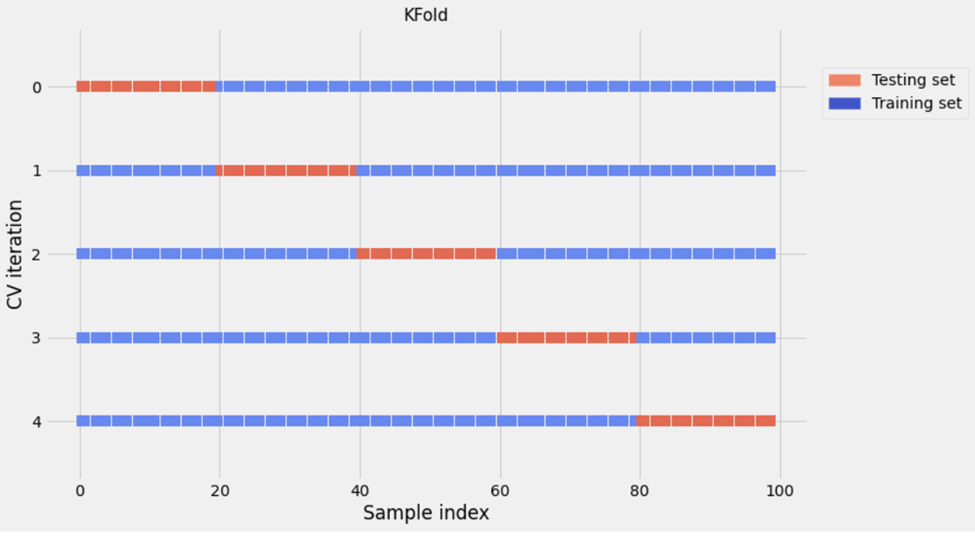

---
---

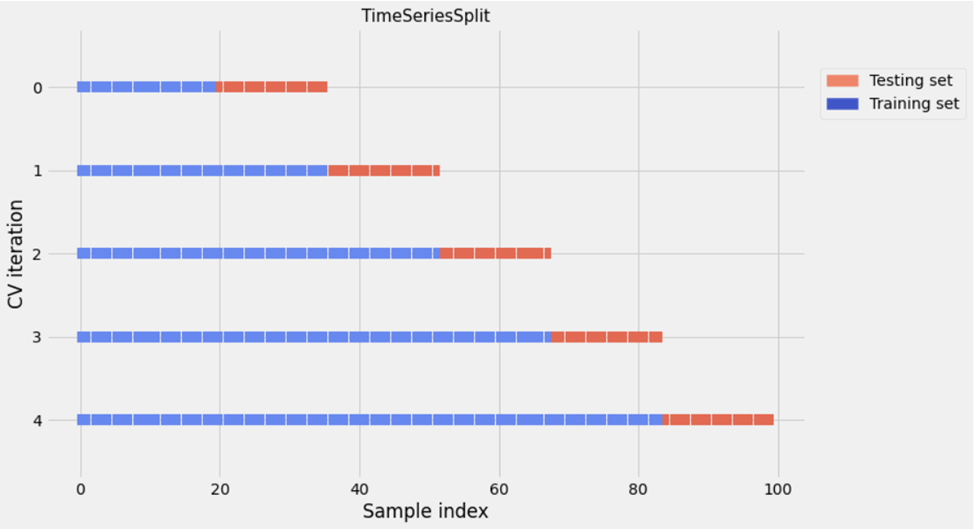

#### Diagrams are from: https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it/notebook

---
---


### Target: y_battles
### Algorithm: Ridge

In [90]:
ridge_pipe = make_pipeline(Ridge(random_state=42, max_iter=100000))
print(ridge_pipe.steps)

[('ridge', Ridge(max_iter=100000, random_state=42))]


In [186]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'ridge__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(ridge_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_battles_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))


{'ridge__alpha': 2.5826187606826747}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -4.8603


In [187]:
print(grid.score(X_test, y_battles_test))



-5.587540975032525


In [190]:
ridge_best = Ridge(alpha=2.5826187606826747, random_state=42, max_iter=100000).fit(X_train, y_battles_train)
y_battles_preds_ridge = ridge_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_battles_test, y_battles_preds_ridge))))


RMSE when Optimal Model is Fit to the Test Set: 5.5875


In [191]:
'''
pickle.dump(ridge_best, open(export_path + "ridge_best_y_battles.pkl", "wb"))

In [313]:
'''
ridge_best = pickle.load(open(export_path + "ridge_best_y_battles.pkl", "rb"))

### Target: y_battles
### Algorithm: Lasso

In [192]:
lasso_pipe = make_pipeline(Lasso(random_state=42, max_iter=100000))
print(lasso_pipe.steps)

[('lasso', Lasso(max_iter=100000, random_state=42))]


In [193]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'lasso__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(lasso_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_battles_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'lasso__alpha': 0.3696912707195028}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -4.8892


In [194]:
lasso_best = Lasso(alpha=0.3696912707195028, random_state=42, max_iter=100000).fit(X_train, y_battles_train)
y_battles_preds_lasso = lasso_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_battles_test, y_battles_preds_lasso))))


RMSE when Optimal Model is Fit to the Test Set: 5.6268


In [71]:
'''
pickle.dump(lasso_best, open(export_path + "lasso_best_y_battles.pkl", "wb"))

In [ ]:
'''
lasso_best = pickle.load(open(export_path + "lasso_best_y_battles.pkl", "rb"))

### Target: y_battles
### Algorithm: Random Forest Regression

In [196]:
rf_pipe = make_pipeline(RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=1, max_features="sqrt"))
print(rf_pipe.steps)

[('randomforestregressor', RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42))]


In [208]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'randomforestregressor__n_estimators': [1000, 2000, 3000, 4000],
             'randomforestregressor__max_depth': [1, 10, 20, 30],
             'randomforestregressor__min_samples_leaf': [1, 5, 10],
             'randomforestregressor__max_features': [170, 220, 270, 320, 370]}
grid = GridSearchCV(rf_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_battles_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 220, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 3000}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -4.6324


In [205]:
rf_best = RandomForestRegressor(random_state=42, n_estimators=3000, max_depth=10, min_samples_leaf=1, max_features=220, n_jobs=-1).fit(X_train, y_battles_train.values.ravel())
y_battles_preds_rf = rf_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_battles_test, y_battles_preds_rf))))


RMSE when Optimal Model is Fit to the Test Set: 5.5692


In [206]:
'''
pickle.dump(rf_best, open(export_path + "rf_best_y_battles.pkl", "wb"))

In [ ]:
'''
rf_best = pickle.load(open(export_path + "rf_best_y_battles.pkl", "rb"))

### Target: y_battles
### Algorithm: XGBoost Regression

In [283]:
xgb_pipe = make_pipeline(XGBRegressor(random_state=42, objective ='reg:squarederror', n_jobs=-1))
print(xgb_pipe.steps)

[('xgbregressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             objective='reg:linear', random_state=42, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=None))]


In [288]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'xgbregressor__n_estimators': [50, 100, 150],
             'xgbregressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
             'xgbregressor__max_depth': [4, 6, 8],
             'xgbregressor__min_child_weight': [1, 3, 5, 7]
             }
grid = GridSearchCV(xgb_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_battles_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

[22:24:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
{'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 7, 'xgbregressor__n_estimators': 50}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -4.1704


In [290]:
xgb_best = XGBRegressor(random_state=42, n_estimators=50, learning_rate=0.05, max_depth=4, min_child_weight=7, n_jobs=-1).fit(X_train, y_battles_train.values.ravel())
y_battles_preds_rf = xgb_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_battles_test, y_battles_preds_rf))))


RMSE when Optimal Model is Fit to the Test Set: 5.4413


In [291]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_battles.pkl", "wb"))

In [ ]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_battles.pkl", "wb"))

---
---

**Comparison of Performance for Models on Cross Validation Data Using y_battles_train and X_train:**

RMSE for:

- XGBoost Regression: 4.1704
- Random Forest Regression: 4.6324
- Ridge Regression: 4.8603
- Lasso Regression: 4.8892


---
---


### Target: y_explosions
### Algorithm: Ridge

In [209]:
ridge_pipe = make_pipeline(Ridge(random_state=42, max_iter=100000))
print(ridge_pipe.steps)

[('ridge', Ridge(max_iter=100000, random_state=42))]


In [211]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'ridge__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(ridge_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_explosions_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'ridge__alpha': 3.1622776601683795}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -1.5569


In [212]:
ridge_best = Ridge(alpha= 3.1622776601683795, random_state=42, max_iter=100000).fit(X_train, y_explosions_train)
y_explosions_preds_ridge = ridge_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_explosions_test, y_explosions_preds_ridge))))

RMSE when Optimal Model is Fit to the Test Set: 1.7543


In [213]:
'''
pickle.dump(ridge_best, open(export_path + "ridge_best_y_explosions.pkl", "wb"))

In [ ]:
'''
ridge_best = pickle.load(open(export_path + "ridge_best_y_explosions.pkl", "rb"))

### Target: y_explosions
### Algorithm: Lasso

In [214]:
lasso_pipe = make_pipeline(Lasso(random_state=42, max_iter=100000))
print(lasso_pipe.steps)

[('lasso', Lasso(max_iter=100000, random_state=42))]


In [215]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'lasso__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(lasso_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_explosions_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'lasso__alpha': 0.07316807143427195}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -1.5465


In [216]:
lasso_best = Lasso(alpha= 0.07316807143427195, random_state=42, max_iter=100000).fit(X_train, y_explosions_train)
y_explosions_preds_lasso = lasso_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_explosions_test, y_explosions_preds_lasso))))

RMSE when Optimal Model is Fit to the Test Set: 1.7357


In [217]:
'''
pickle.dump(lasso_best, open(export_path + "lasso_best_y_explosions.pkl", "wb"))

In [ ]:
'''
pickle.dump(lasso_best, open(export_path + "lasso_best_y_explosions.pkl", "wb"))

### Target: y_explosions
### Algorithm: Random Forest Regression

In [250]:
from sklearn.ensemble import RandomForestRegressor

In [251]:
rf_pipe = make_pipeline(RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=1, max_features="sqrt"))
print(rf_pipe.steps)

[('randomforestregressor', RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42))]


In [275]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'randomforestregressor__n_estimators': [1000, 2000, 3000, 4000],
             'randomforestregressor__max_depth': [1, 10, 20, 30],
             'randomforestregressor__min_samples_leaf': [1, 5, 10],
             'randomforestregressor__max_features': [170, 220, 270, 320, 370]}
grid = GridSearchCV(rf_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_explosions_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 320, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 3000}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -1.5342


In [221]:
rf_best = RandomForestRegressor(random_state=42, n_estimators=3000, max_depth=10, min_samples_leaf=1, max_features=320, n_jobs=-1).fit(X_train, y_explosions_train.values.ravel())
y_explosions_preds_rf = rf_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_explosions_test, y_explosions_preds_rf))))

RMSE when Optimal Model is Fit to the Test Set: 1.7481


In [222]:
'''
pickle.dump(rf_best, open(export_path + "rf_best_y_explosions.pkl", "wb"))

In [ ]:
'''
rf_best = pickle.load(open(export_path + rf_best_y_explosions.pkl", "rb"))

### Target: y_explosions
### Algorithm: XGBoost Regression

In [292]:
xgb_pipe = make_pipeline(XGBRegressor(random_state=42, objective ='reg:squarederror', n_jobs=-1))
print(xgb_pipe.steps)

[('xgbregressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None))]


In [293]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'xgbregressor__n_estimators': [50, 100, 150],
             'xgbregressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
             'xgbregressor__max_depth': [4, 6, 8],
             'xgbregressor__min_child_weight': [1, 3, 5, 7]
             }
grid = GridSearchCV(xgb_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_explosions_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 7, 'xgbregressor__n_estimators': 100}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -1.4564


In [294]:
xgb_best = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.2, max_depth=4, min_child_weight=7, n_jobs=-1).fit(X_train, y_explosions_train.values.ravel())
y_explosions_preds_rf = xgb_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_explosions_test, y_explosions_preds_rf))))


RMSE when Optimal Model is Fit to the Test Set: 1.7689


In [295]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_explosions.pkl", "wb"))

In [ ]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_explosions.pkl", "wb"))


---
---

**Comparison of Performance for Models on Cross Validation Data Using y_explosions_train and X_train:**

RMSE for:

- XGBoost Regression: 1.4564
- Random Forest Regression: 1.5342
- Lasso Regression: 1.5465
- Ridge Regression: 1.5569

---
---


### Target: y_protests
### Algorithm: Ridge

In [107]:
ridge_pipe = make_pipeline(Ridge(random_state=42, max_iter=100000))
print(ridge_pipe.steps)

[('ridge', Ridge(max_iter=100000, random_state=42))]


In [224]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'ridge__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(ridge_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_protests_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'ridge__alpha': 3.1622776601683795}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -108.2137


In [225]:
ridge_best = Ridge(alpha= 3.1622776601683795, random_state=42, max_iter=100000).fit(X_train, y_protests_train)
y_protests_preds_ridge = ridge_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_protests_test, y_protests_preds_ridge))))

RMSE when Optimal Model is Fit to the Test Set: 116.6480


In [226]:
'''
pickle.dump(ridge_best, open(export_path + "ridge_best_y_protests.pkl", "wb"))

In [ ]:
'''
ridge_best = pickle.load(open(export_path + "ridge_best_y_protests.pkl", "rb"))

### Target: y_protests
### Algorithm: Lasso

In [112]:
lasso_pipe = make_pipeline(Lasso(random_state=42, max_iter=100000))
print(lasso_pipe.steps)

[('lasso', Lasso(max_iter=100000, random_state=42))]


In [227]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'lasso__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(lasso_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_protests_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'lasso__alpha': 1.7225859653987856}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -107.6887


In [228]:
lasso_best = Lasso(alpha=1.7225859653987856, random_state=42, max_iter=100000).fit(X_train, y_protests_train)
y_protests_preds_lasso = lasso_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_protests_test, y_protests_preds_lasso))))

RMSE when Optimal Model is Fit to the Test Set: 115.6709


In [229]:
'''
pickle.dump(lasso_best, open(export_path + "lasso_best_y_protests.pkl", "wb"))

In [ ]:
'''
lasso_best = pickle.load(open(export_path + "lasso_best_y_protests.pkl", "rb"))

### Target: y_protests
### Algorithm: Random Forest Regression

In [230]:
from sklearn.ensemble import RandomForestRegressor

In [231]:
rf_pipe = make_pipeline(RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=1, max_features="sqrt"))
print(rf_pipe.steps)

[('randomforestregressor', RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42))]


In [232]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'randomforestregressor__n_estimators': [1000, 2000, 3000, 4000],
             'randomforestregressor__max_depth': [1, 10, 20, 30],
             'randomforestregressor__min_samples_leaf': [1, 5, 10],
             'randomforestregressor__max_features': [170, 220, 270, 320, 370]}
grid = GridSearchCV(rf_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_protests_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'randomforestregressor__max_depth': 1, 'randomforestregressor__max_features': 320, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__n_estimators': 2000}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -107.4333


In [233]:
rf_best = RandomForestRegressor(random_state=42, n_estimators=2000, max_depth=1, min_samples_leaf=10, max_features=320, n_jobs=-1).fit(X_train, y_protests_train.values.ravel())
y_protests_preds_rf = rf_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_protests_test, y_protests_preds_rf))))

RMSE when Optimal Model is Fit to the Test Set: 117.9724


In [234]:
'''
pickle.dump(rf_best, open(export_path + "rf_best_y_protests.pkl", "wb"))

In [ ]:
'''
rf_best = pickle.load(open(export_path + "rf_best_y_protests.pkl", "rb"))

### Target: y_protests
### Algorithm: XGBoost Regression

In [297]:
xgb_pipe = make_pipeline(XGBRegressor(random_state=42, objective ='reg:squarederror', n_jobs=-1))
print(xgb_pipe.steps)

[('xgbregressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None))]


In [298]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'xgbregressor__n_estimators': [50, 100, 150],
             'xgbregressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
             'xgbregressor__max_depth': [4, 6, 8],
             'xgbregressor__min_child_weight': [3, 5, 7]
             }
grid = GridSearchCV(xgb_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_protests_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 7, 'xgbregressor__n_estimators': 50}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -116.9903


In [299]:
xgb_best = XGBRegressor(random_state=42, n_estimators= 50, learning_rate=0.05, max_depth=4, min_child_weight=7, n_jobs=-1).fit(X_train, y_protests_train.values.ravel())
y_protests_preds_rf = xgb_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_protests_test, y_protests_preds_rf))))


RMSE when Optimal Model is Fit to the Test Set: 124.2078


In [300]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_protests.pkl", "wb"))

In [ ]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_protests.pkl", "wb"))


---
---

**Comparison of Performance for Models on Cross Validation Data Using y_protests_train and X_train:**

RMSE for:

- Random Forest Regression: 107.4333
- Lasso Regression: 107.6887
- Ridge Regression: 108.2137
- XGBoost Regression: 116.9903

---
---


### Target: y_riots
### Algorithm: Ridge

In [238]:
ridge_pipe = make_pipeline(Ridge(random_state=42, max_iter=100000))
print(ridge_pipe.steps)

[('ridge', Ridge(max_iter=100000, random_state=42))]


In [239]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'ridge__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(ridge_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_riots_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'ridge__alpha': 3.1622776601683795}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -2.5179


In [240]:
ridge_best = Ridge(alpha= 3.1622776601683795, random_state=42, max_iter=100000).fit(X_train, y_riots_train)
y_riots_preds_ridge = ridge_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_riots_test, y_riots_preds_ridge))))

RMSE when Optimal Model is Fit to the Test Set: 2.2682


In [241]:
'''
pickle.dump(ridge_best, open(export_path + "ridge_best_y_riots.pkl", "wb"))

In [ ]:
'''
ridge_best = pickle.load(open(export_path + "ridge_best_y_riots.pkl", "rb"))

### Target: y_riots
### Algorithm: Lasso

In [242]:
lasso_pipe = make_pipeline(Lasso(random_state=42, max_iter=100000))
print(lasso_pipe.steps)

[('lasso', Lasso(max_iter=100000, random_state=42))]


In [243]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'lasso__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(lasso_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_riots_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'lasso__alpha': 0.07934096665797492}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -2.4961


In [244]:
lasso_best = Lasso(alpha=0.07934096665797492, random_state=42, max_iter=100000).fit(X_train, y_riots_train)
y_riots_preds_lasso = lasso_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_riots_test, y_riots_preds_lasso))))

RMSE when Optimal Model is Fit to the Test Set: 2.2411


In [245]:
'''
pickle.dump(lasso_best, open(export_path + "lasso_best_y_riots.pkl", "wb"))

In [ ]:
'''
lasso_best = pickle.load(open(export_path + "lasso_best_y_riots.pkl", "rb"))

### Target: y_riots
### Algorithm: Random Forest Regression

In [246]:
from sklearn.ensemble import RandomForestRegressor

In [247]:
rf_pipe = make_pipeline(RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=1, max_features="sqrt"))
print(rf_pipe.steps)

[('randomforestregressor', RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42))]


In [248]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'randomforestregressor__n_estimators': [1000, 2000, 3000, 4000],
             'randomforestregressor__max_depth': [1, 10, 20, 30],
             'randomforestregressor__min_samples_leaf': [1, 5, 10],
             'randomforestregressor__max_features': [170, 220, 270, 320, 370]}
grid = GridSearchCV(rf_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_riots_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'randomforestregressor__max_depth': 1, 'randomforestregressor__max_features': 370, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 2000}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -2.3903


In [257]:
rf_best = RandomForestRegressor(random_state=42, n_estimators=2000, max_depth=1, min_samples_leaf=1, max_features=370, n_jobs=-1).fit(X_train, y_riots_train.values.ravel())
y_riots_preds_rf = rf_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_riots_test, y_riots_preds_rf))))

RMSE when Optimal Model is Fit to the Test Set: 2.1061


In [258]:
'''
pickle.dump(rf_best, open(export_path + "rf_best_y_riots.pkl", "wb"))

In [ ]:
'''
rf_best = pickle.load(open(export_path + "rf_best_y_riots.pkl", "rb"))

### Target: y_riots
### Algorithm: XGBoost Regression

In [301]:
xgb_pipe = make_pipeline(XGBRegressor(random_state=42, objective ='reg:squarederror', n_jobs=-1))
print(xgb_pipe.steps)

[('xgbregressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None))]


In [302]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'xgbregressor__n_estimators': [50, 100, 150],
             'xgbregressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
             'xgbregressor__max_depth': [4, 6, 8],
             'xgbregressor__min_child_weight': [3, 5, 7]
             }
grid = GridSearchCV(xgb_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_riots_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 5, 'xgbregressor__n_estimators': 50}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -2.1890


In [303]:
xgb_best = XGBRegressor(random_state=42, n_estimators=50, learning_rate=0.05, max_depth=4, min_child_weight=5, n_jobs=-1).fit(X_train, y_riots_train.values.ravel())
y_riots_preds_rf = xgb_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_riots_test, y_riots_preds_rf))))


RMSE when Optimal Model is Fit to the Test Set: 1.9828


In [304]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_riots.pkl", "wb"))

In [ ]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_riots.pkl", "wb"))

---
---

**Comparison of Performance for Models on Cross Validation Data Using y_riots_train and X_train:**


RMSE for:

- XGBoost Regression: 2.1890
- Random Forest Regression: 2.3903
- Lasso Regression: 2.4961
- Ridge Regression: 2.5179


---
---


### Target: y_vac
### Algorithm: Ridge

In [260]:
ridge_pipe = make_pipeline(Ridge(random_state=42, max_iter=100000))
print(ridge_pipe.steps)

[('ridge', Ridge(max_iter=100000, random_state=42))]


In [261]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'ridge__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(ridge_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_vac_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'ridge__alpha': 0.02171117945694504}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -119.6204


In [262]:
ridge_best = Ridge(alpha=0.02171117945694504, random_state=42, max_iter=100000).fit(X_train, y_vac_train)
y_vac_preds_ridge = ridge_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_vac_test, y_vac_preds_ridge))))

RMSE when Optimal Model is Fit to the Test Set: 157.2134


In [263]:
'''
pickle.dump(ridge_best, open(export_path + "ridge_best_y_vac.pkl", "wb"))

In [ ]:
'''
ridge_best = pickle.load(open(export_path + "ridge_best_y_vac.pkl", "rb"))

### Target: y_vac
### Algorithm: Lasso

In [264]:
lasso_pipe = make_pipeline(Lasso(random_state=42, max_iter=100000))
print(lasso_pipe.steps)

[('lasso', Lasso(max_iter=100000, random_state=42))]


In [265]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'lasso__alpha': np.logspace(-3, 0.5, 200)}
grid = GridSearchCV(lasso_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_vac_train)
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'lasso__alpha': 0.16446761779946645}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -118.2845


In [266]:
lasso_best = Lasso(alpha=0.16446761779946645, random_state=42, max_iter=100000).fit(X_train, y_vac_train)
y_vac_preds_lasso = lasso_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_vac_test, y_vac_preds_lasso))))

RMSE when Optimal Model is Fit to the Test Set: 159.3633


In [267]:
'''
pickle.dump(lasso_best, open(export_path + "lasso_best_y_vac.pkl", "wb"))

In [ ]:
'''
lasso_best = pickle.load(open(export_path + "lasso_best_y_vac.pkl", "rb"))

### Target: y_vac
### Algorithm: Random Forest Regression

In [268]:
from sklearn.ensemble import RandomForestRegressor

In [269]:
rf_pipe = make_pipeline(RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=1, max_features="sqrt"))
print(rf_pipe.steps)

[('randomforestregressor', RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42))]


In [270]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'randomforestregressor__n_estimators': [1000, 2000, 3000, 4000],
             'randomforestregressor__max_depth': [1, 10, 20, 30],
             'randomforestregressor__min_samples_leaf': [1, 5, 10],
             'randomforestregressor__max_features': [170, 220, 270, 320, 370]}
grid = GridSearchCV(rf_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_vac_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 270, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__n_estimators': 2000}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -127.2781


In [271]:
rf_best = RandomForestRegressor(random_state=42, n_estimators=2000, max_depth=10, min_samples_leaf=5, max_features=270, n_jobs=-1).fit(X_train, y_vac_train.values.ravel())
y_vac_preds_rf = rf_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_vac_test, y_vac_preds_rf))))

RMSE when Optimal Model is Fit to the Test Set: 121.5632


In [272]:
'''
pickle.dump(rf_best, open(export_path + "rf_best_y_vac.pkl", "wb"))

In [ ]:
'''
rf_best = pickle.load(open(export_path + "rf_best_y_vac.pkl", "rb"))

### Target: y_riots
### Algorithm: XGBoost Regression

In [301]:
xgb_pipe = make_pipeline(XGBRegressor(random_state=42, objective ='reg:squarederror', n_jobs=-1))
print(xgb_pipe.steps)

[('xgbregressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None))]


In [306]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'xgbregressor__n_estimators': [50, 100, 150],
             'xgbregressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
             'xgbregressor__max_depth': [4, 6, 8],
             'xgbregressor__min_child_weight': [3, 5, 7]
             }
grid = GridSearchCV(xgb_pipe, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_vac_train.values.ravel())
print(grid.best_params_)
print('Mean RMSE when Optimal Model is Fit to Cross Validation Data: {:.4f}'.format(grid.best_score_))

{'xgbregressor__learning_rate': 0.15, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 7, 'xgbregressor__n_estimators': 150}
Mean RMSE when Optimal Model is Fit to Cross Validation Data: -123.4189


In [310]:
xgb_best = XGBRegressor(random_state=42, n_estimators=150, learning_rate=0.15, max_depth=4, min_child_weight=7, n_jobs=-1).fit(X_train, y_vac_train.values.ravel())
y_vac_preds_xgb = xgb_best.predict(X_test)
print('RMSE when Optimal Model is Fit to the Test Set: {:.4f}'.format(sqrt(mean_squared_error(y_vac_test, y_vac_preds_xgb))))


RMSE when Optimal Model is Fit to the Test Set: 158.5494


In [311]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_vac.pkl", "wb"))

In [ ]:
'''
pickle.dump(xgb_best, open(export_path + "xgb_best_y_vac.pkl", "wb"))

---
---

**Comparison of Performance for Models on Cross Validation Data Using y_vac_train and X_train:**

RMSE for:

- Lasso Regression: 118.2845
- Ridge Regression: 119.6204
- XGBoost Regression: 123.4189
- Random Forest Regression: 127.2781

---
---


### **Summary:**

### In general, a good RMSE score is considered to be 0.5 or lower. Although none of the models predicted the ACLED political violence event types (or changes in event types) very well, they performed best when predicting explosions or remote violence, followed by prediting riots. They performed worst when predicting weekly changes in events involving violence against civilians, and also weekly changes in the number of protests in which excessive police force was used. XGBoost performed better than the other models in all event type categories except predicting changes in the number of events involving violence against civilians and changes in the number of protests in which excessive police force was used. In these 2 cases, XGBoost was one of the worst performing models.  Random Forests was the best model in terms of predicting changes in the number of protests in which excessive police force was used, and the second best model in terms of predicting the number of battles, the number of explosions or remote violence, and the number of riots.